In [32]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df=pd.read_csv('../data/bikedata.csv')
df.head()

,name,latitude,longitude,free_bikes,empty_slots,total_bike_cap,uid,renting,returning,last_updated,has_ebikes,ebikes,payment,payment-terminal,slots,rental_uris.android,rental_uris.ios
0,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,True,3,"['key', 'creditcard']",True,12,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
1,South St & University Dr,38.844249,-77.305336,11,1,12,1877158937567185816,1,1,1729395487,True,0,"['key', 'creditcard']",True,12,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
2,White Oak Rec Center,39.046143,-76.975723,6,9,15,2213781a-5c69-43eb-9b33-346d61e7e1ba,1,1,1729395477,True,0,"['key', 'creditcard']",True,15,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
3,Fessenden St & Wisconsin Ave NW,38.954812,-77.082426,1,14,15,08254529-1f3f-11e7-bf6b-3863bb334450,1,1,1729395578,True,0,"['key', 'creditcard']",True,15,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
4,Fenton St & Gist Ave,38.989724,-77.023854,6,5,11,0825ac97-1f3f-11e7-bf6b-3863bb334450,1,1,1729395538,True,5,"['key', 'creditcard']",True,11,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan


# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [19]:
api_key = os.environ['foursquareapi']
latitude = ""
longitude = ''
radius = str(500)
categories = '13003,12057,12061'
headers = {"Accept": "application/json"}
headers['Authorization'] = api_key
foursquaredata = pd.DataFrame()

for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    url = f"https://api.foursquare.com/v3/places/search?ll={latitude},{longitude}&radius={radius}&categories={categories}&fields=name,rating,location,popularity,distance,categories"
    result = requests.get(url, headers=headers)
    data = result.json()
    result_df = pd.json_normalize(data.get('results', []))
    if not result_df.empty:
        result_df['station'] = row['name']
        foursquaredata = pd.concat([foursquaredata, result_df], ignore_index=True)



Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc). 

In [37]:
foursquaredata.head()

,categories,distance,name,popularity,rating,location.address,location.census_block,location.country,location.cross_street,location.dma,location.formatted_address,location.locality,location.postcode,location.region,location.address_extended,station
0,"[{'id': 13003, 'name': 'Bar', 'short_name': 'B...",97,The Liberty Tavern,0.982389,8.5,3195 Wilson Blvd,510131015022016,US,Washington Blvd,"Washington, Dc-Hagrstwn","3195 Wilson Blvd (Washington Blvd), Arlington,...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
1,"[{'id': 13003, 'name': 'Bar', 'short_name': 'B...",240,Lyon Hall,0.982187,8.5,3100 Washington Blvd,510131019001002,US,at N Highland St.,"Washington, Dc-Hagrstwn","3100 Washington Blvd (at N Highland St.), Arli...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
2,"[{'id': 13007, 'name': 'Beer Garden', 'short_n...",131,The Lot,0.972111,8.0,3217 10th St N,510131019001004,US,,"Washington, Dc-Hagrstwn","3217 10th St N, Arlington, VA 22201",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
3,"[{'id': 13015, 'name': 'Karaoke Bar', 'short_n...",62,O'Sullivan's Irish Pub,0.980685,7.5,3207 Washington Blvd,510131015022017,US,at Wilson Blvd.,"Washington, Dc-Hagrstwn","3207 Washington Blvd (at Wilson Blvd.), Arling...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
4,"[{'id': 13025, 'name': 'Wine Bar', 'short_name...",442,Screwtop Wine Bar,0.965211,8.5,1025 N Fillmore St,510131018011002,US,NaN,"Washington, Dc-Hagrstwn","1025 N Fillmore St, Arlington, VA 22201",Arlington,22201,VA,Ste C,Fairfax Dr & Wilson Blvd


There are 56 null values in foursquare ratings but I am keeping them in for now because I want to see them with the yelp data in the next stage. The data may be offices and that makes sense that no one has rated them yet.

In [39]:
foursquareparsed = foursquaredata[['station','distance','name','location.address','rating','popularity','categories']]
foursquareparsed.loc[:, 'categories']= foursquareparsed['categories'].apply(lambda x: [cat['name'] for cat in x])

In [40]:
foursquareparsed.loc[:, 'categories'] = foursquareparsed['categories'].apply(lambda x: 'bar' if any('bar' in category.lower() for category in x) or any('pub' in category.lower() for category in x) or any('restaurant' in category.lower() for category in x) else 'school')

# Foursquare EDA

In [41]:
print(f"Shape of the dataset: {foursquareparsed.shape}")

print(foursquareparsed.head())

print(foursquareparsed.info())

print(foursquareparsed.isnull().sum())

print(foursquareparsed.describe())

Shape of the dataset: (389, 7)
                    station  distance                    name  \
0  Fairfax Dr & Wilson Blvd        97      The Liberty Tavern   
1  Fairfax Dr & Wilson Blvd       240               Lyon Hall   
2  Fairfax Dr & Wilson Blvd       131                 The Lot   
3  Fairfax Dr & Wilson Blvd        62  O'Sullivan's Irish Pub   
4  Fairfax Dr & Wilson Blvd       442       Screwtop Wine Bar   

       location.address  rating  popularity categories  
0      3195 Wilson Blvd     8.5    0.982389        bar  
1  3100 Washington Blvd     8.5    0.982187        bar  
2        3217 10th St N     8.0    0.972111        bar  
3  3207 Washington Blvd     7.5    0.980685        bar  
4    1025 N Fillmore St     8.5    0.965211        bar  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           389 non-null   

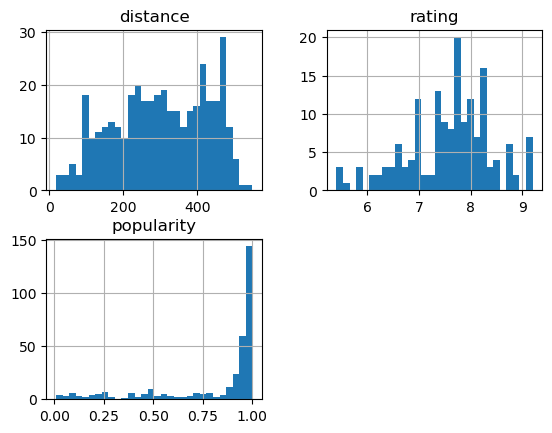

In [42]:
foursquareparsed.hist(bins=30)
plt.show()

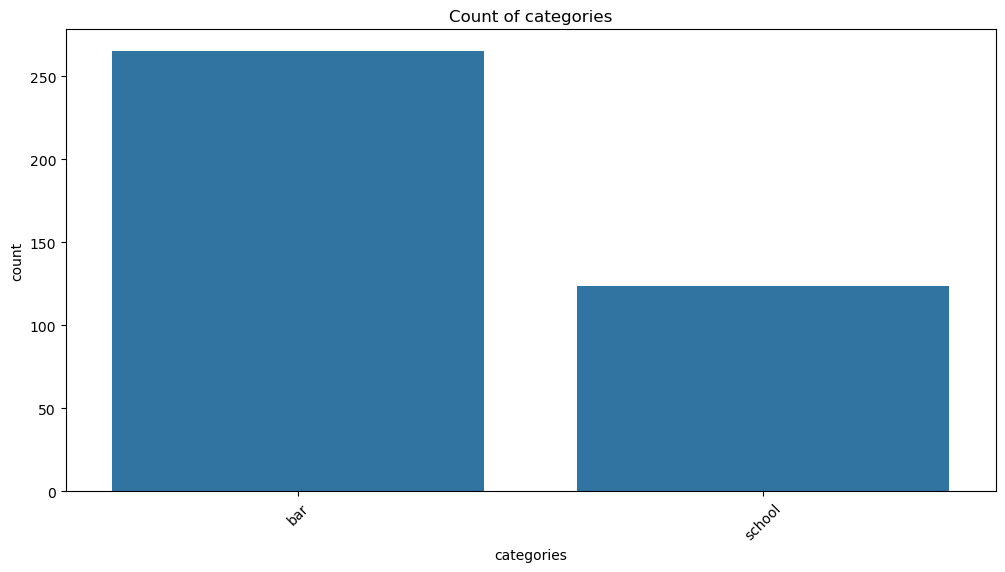

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(data=foursquareparsed, x='categories')
plt.xticks(rotation=45)
plt.title('Count of categories')
plt.show()

Results into CSV for next steps

In [51]:
foursquareparsed.to_csv('../data/foursqdata.csv', index=False)

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [52]:
yelp_api_key = os.environ['yelpapi']
latitude = ""
longitude = ''
radius = str(500)
categories = 'bars,elementaryschools,highschools,privateschools'
headers = {"Accept": "application/json"}
headers['Authorization'] = f"Bearer {yelp_api_key}"
yelpdataframes = []
for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    url = f"https://api.yelp.com/v3/businesses/search?latitude={latitude}&longitude={longitude}&radius={radius}&categories={categories}"
    result = requests.get(url, headers=headers)
    print(f"Status: {result.status_code}")
    data = result.json()
    result_df = pd.json_normalize(data.get('businesses', []))
    if not result_df.empty:
        result_df['station'] = row['name']
        yelpdataframes.append(result_df)
yelpdata = pd.concat(yelpdataframes, ignore_index=True) if yelpdataframes else pd.DataFrame()


Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200


Confirming all stations are present. Parsing data and then renaming column to match Foursquare. 

In [53]:
yelpdata['station'].unique()
yelpdata.keys()

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'transactions', 'price', 'phone',
       'display_phone', 'distance', 'business_hours', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address',
       'attributes.business_temp_closed', 'attributes.menu_url',
       'attributes.open24_hours', 'attributes.waitlist_reservation',
       'station'],
      dtype='object')

In [54]:
len(yelpdata)

534

In [55]:
yelpdata['rating'].isnull().sum()

0

In [8]:
yelpparsed = yelpdata[['station','distance','name','location.address1','rating']]
yelpparsed=yelpparsed.rename(columns={'location.address1': 'location.address'})


### Dealing with duplicates

In [9]:
namecount = yelpparsed.groupby(['name', 'station']).size().reset_index(name='count')
namecount[namecount['count']>1].sort_values(by='count',ascending=False)
yelpparsed=yelpparsed.drop_duplicates(subset='name')


Results into a CSV for next steps

In [10]:
yelpparsed.to_csv('yelpdata.csv', index=False)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

Foursquare provided more complete data because they provide clear documentation around categories and filtering. Yelp's lack of category definitions means that there is more uncertainty around what you are able to pull. 

Get the top 10 restaurants according to their rating

Yelp top 10

In [ ]:
yelptop10 = yelpparsed.sort_values(by='rating', ascending=False).reset_index(drop=True).head(10)
yelptop10

Foursquare top 10

In [ ]:
foursqtop10 = foursquareparsed.sort_values(by='rating', ascending=False).reset_index(drop=True).head(10)
foursqtop10